In [ ]:
%matplotlib inline

In [1]:
%load_ext autoreload
%autoreload 2

# Лабораторная работа №2, часть 1

In [ ]:
from functools import partial
from itertools import islice
from typing import NamedTuple

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
from more_itertools import last
from nptyping import Array
from scipy.optimize import OptimizeResult, minimize
from scipy.special import expit, xlog1py

from common import learning_rate_gen, loss_convergence_display

## Загрузка данных

In [3]:
ParamType = np.single

PARAM_COUNT = 3
ParamVector = Array[ParamType, 0, PARAM_COUNT]
ParamMatrix = Array[ParamType, ..., PARAM_COUNT]

EXAM_1_COLUMN_NAME = "exam_1"
EXAM_2_COLUMN_NAME = "exam_2"
HAS_ENTERED_COLUMN_NAME = "has_entered"

FEATURE_COLUMNS = [EXAM_1_COLUMN_NAME, EXAM_2_COLUMN_NAME]

data = pd.read_csv(
    "ex2data1.txt",
    header=None,
    names=[EXAM_1_COLUMN_NAME, EXAM_2_COLUMN_NAME, HAS_ENTERED_COLUMN_NAME],
    dtype=ParamType,
)

print(data.head())

FEATURES: ParamMatrix = np.insert(
    data[FEATURE_COLUMNS].to_numpy(), 0, np.ones(len(data)), axis=1
)

TARGETS: ParamVector = data[HAS_ENTERED_COLUMN_NAME].to_numpy()


      exam_1     exam_2  has_entered
0  34.623661  78.024696          0.0
1  30.286711  43.894997          0.0
2  35.847408  72.902199          0.0
3  60.182598  86.308556          1.0
4  79.032738  75.344376          1.0


## Отображение входных данных

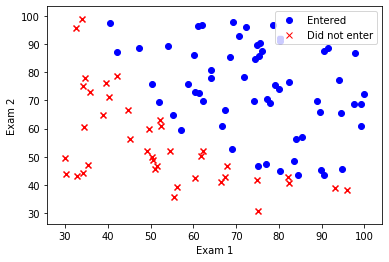

In [4]:
class ElementMarker(NamedTuple):
    marker: str
    color: str
    label: str


entered_marker = ElementMarker(marker="o", color="blue", label="Entered")
did_not_enter_marker = ElementMarker(marker="x", color="red", label="Did not enter")

legend_elements = [
    Line2D(
        [0],
        [0],
        marker=element_marker.marker,
        color="w",
        markerfacecolor=element_marker.color,
        markeredgecolor=element_marker.color,
        label=element_marker.label,
    )
    for element_marker in (entered_marker, did_not_enter_marker)
]

data_fig, data_axes = plt.subplots()

for row in data.itertuples():
    element_marker = entered_marker if row.has_entered else did_not_enter_marker
    data_axes.scatter(
        row.exam_1, row.exam_2, marker=element_marker.marker, c=element_marker.color
    )

data_axes.set_xlabel("Exam 1")
data_axes.set_ylabel("Exam 2")
data_axes.legend(handles=legend_elements, loc="upper right")
plt.show()


### Представление гипотезы
$$
\begin{equation}
\large
h_{\theta}(x) = g(\theta^{T}x)
\end{equation}
$$

$$
\begin{equation}
g(z) = \dfrac{1}{1 + e^{-z}}
\end{equation}
$$

In [5]:
def sigmoid(theta: ParamVector, x: ParamMatrix) -> ParamVector:
    return expit(x @ theta)


def hypothesis(theta: ParamVector, x: ParamMatrix) -> ParamVector:
    assert theta.shape[0] == x.shape[1]

    return sigmoid(theta=theta, x=x)


assert np.array_equal(
    np.ones(3), hypothesis(np.repeat(float("inf"), 3), np.ones((3, 3)))
)


### Функция стоимости для элемента
$$
\begin{align*}
\mathrm{Cost}(h_{\theta}(x), y) = -\log(h_{\theta}(x)) \; \text{ где y = 1 }\\
\mathrm{Cost}(h_{\theta}(x), y) = -\log(1 - h_{\theta}(x)) \; \text{ где y = 0 }
\end{align*}
$$

или

$$
\begin{align*}
\normalsize
\mathrm{Cost}(h_{\theta}(x), y) =
-y\log(h_{\theta}(x)) - (1 - y) \log(1 - h_{\theta}(x))
\end{align*}
$$

In [6]:
def cost(h: ParamVector, y: ParamVector) -> ParamType:
    """Element-wise cost function."""
    assert h.shape == y.shape

    return np.multiply(-y, np.log(h)) - xlog1py(1 - y, -h)


assert np.array_equal(np.zeros(3), cost(np.ones(3), np.ones(3)))


### Полная функция стоимости
$$
\begin{equation}
\large
J(\theta) = \dfrac{1}{m} \sum_{i=0}^{m} \mathrm{Cost}(h_{\theta}(x^{(i)}, y^{(i)}) =\\
= -\dfrac{1}{m} \sum_{i=0}^{m}
\left[
y^{(i)}\log(h_{\theta}(x^{(i)}))
+ (1 - y^{(i)}) \log(1 - h_{\theta}(x^{(i)}))
\right]
\end{equation}
$$

In [7]:
def loss(theta: ParamVector, x: ParamMatrix, y: ParamVector) -> ParamType:
    """Total cost function."""
    length = y.shape[0]
    assert length == x.shape[0]
    assert x.shape[1] == theta.shape[0]

    return np.sum(cost(hypothesis(theta, x), y)) / length


assert 0 == loss(np.repeat(float("inf"), 3), np.ones((3, 3)), np.ones(3))


## Градиентный спуск

$$
\large
\theta_j := \theta_j - \frac{\alpha}{m}
\sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}
$$

### Векторная форма

$$
\large
\theta = \theta - \frac{\alpha}{m} X^T (g(\theta^T X) - y)
$$

In [8]:
def gradient_descent(
    learning_rate: ParamType,
    theta: ParamVector,
    x: ParamMatrix,
    y: ParamVector,
    precision: ParamType = ParamType("0.0"),
) -> ParamVector:
    length = y.shape[0]
    assert length == x.shape[0]
    assert theta.shape[0] == x.shape[1]

    coefficient = learning_rate / length
    x_transposed = x.T
    while True:
        new_theta = theta - coefficient * (
            x_transposed @ (hypothesis(theta=theta, x=x) - y)
        )
        yield new_theta

        if np.allclose(theta, new_theta, atol=precision, rtol=0):
            break

        theta = new_theta


assert np.array_equal(
    np.repeat(float("inf"), 3),
    next(gradient_descent(1, np.repeat(float("inf"), 3), np.ones((3, 3)), np.ones(3))),
)


## Поиск оптимального значения скорости обучения

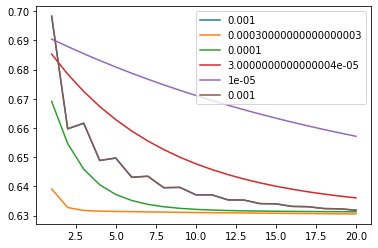

In [9]:
ITERATIONS_LIMIT = 20

THETA_START = np.repeat(ParamType(0), len(FEATURE_COLUMNS) + 1)

loss_for_theta = partial(loss, x=FEATURES, y=TARGETS)
gradient_descent_for_learning_rate = partial(
    gradient_descent, theta=THETA_START, x=FEATURES, y=TARGETS
)

learning_rate_fig, learning_rate_axes = plt.subplots()
for learning_rate in islice(learning_rate_gen(1e-3), 5):
    loss_convergence_display(
        learning_rate_axes,
        learning_rate,
        thetas=gradient_descent_for_learning_rate(learning_rate),
        loss_for_theta=loss_for_theta,
        max_iterations=ITERATIONS_LIMIT,
    )

# Оптимальное значение
LEARNING_RATE = ParamType("1e-3")
loss_convergence_display(
    learning_rate_axes,
    LEARNING_RATE,
    thetas=gradient_descent_for_learning_rate(LEARNING_RATE),
    loss_for_theta=loss_for_theta,
    max_iterations=ITERATIONS_LIMIT,
)

plt.legend()
plt.show()


## Поиск решения

In [10]:
iterations, theta = last(
    enumerate(
        islice(
            gradient_descent(
                LEARNING_RATE, THETA_START, FEATURES, TARGETS, ParamType("1e-6")
            ),
            100000,
        ),
        1,
    )
)
print(f"iterations = {iterations}")
print(f"theta = {theta}")
print(f"loss = {loss(theta, FEATURES, TARGETS)}")


iterations = 100000
theta = [-4.811693    0.04527983  0.03819065]
loss = 0.3873931121826172


## Построение разделяющей прямой

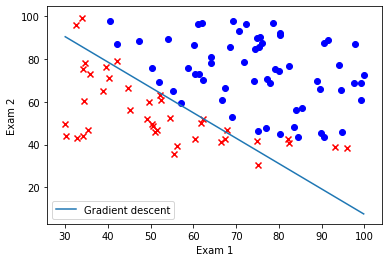

In [11]:
def display_decision_boundary(
    axes: Axes, theta: ParamVector, x: ParamVector, label="Decision boundary"
):
    slope = -theta[1] / theta[2]
    intercept = -theta[0] / theta[2]

    y = [intercept + slope * x_i for x_i in x]
    axes.plot(x, y, label=label)


exam_1_min = min(FEATURES[:, 1])
exam_1_max = max(FEATURES[:, 1])

decision_x = [exam_1_min, exam_1_max]

decision_boundary_for_theta = partial(display_decision_boundary, x=decision_x)

decision_boundary_for_theta(data_axes, theta, label="Gradient descent")
data_axes.legend()
data_fig


## Функция предсказания вероятности поступления студентов

In [12]:
def predict(theta: ParamVector, x: ParamMatrix) -> ParamVector:
    return (x @ theta) >= ParamType("0.5")


def get_score(predictions: ParamVector, targets: ParamVector) -> float:
    length = len(predictions)
    assert length == len(targets)
    return sum(predictions == targets) / length


gradient_score = get_score(predict(theta, FEATURES), TARGETS.astype(np.bool))
print(f"Gradient descent score = {gradient_score:.1%}")


Gradient descent score = 89.0%


### Отображение результатов оптимизации

In [13]:
def display_optimization(optimize_result: OptimizeResult, ax: Axes, label=None):
    print(f"iterations = {optimize_result.nit}")
    print(f"theta = {optimize_result.x}")
    print(f"loss = {optimize_result.fun}")
    score = get_score(predict(optimize_result.x, FEATURES), TARGETS)
    print(f"score = {score:.1%}")
    decision_boundary_for_theta(axes=ax, theta=optimize_result.x, label=label)
    ax.legend()


## Метод оптимизации Нелдера — Мида

iterations = 179
theta = [-25.16133117   0.2062317    0.20147157]
loss = 0.2034977072931657
score = 89.0%


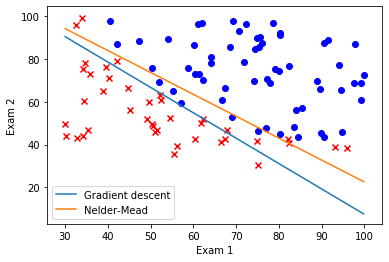

In [14]:
nelder_mead_optimization = minimize(
    fun=loss,
    x0=THETA_START,
    args=(FEATURES, TARGETS),
    method="Nelder-Mead",
    tol=ParamType("1e-6"),
)
display_optimization(nelder_mead_optimization, data_axes, "Nelder-Mead")
data_fig


## Алгоритм Бройдена — Флетчера — Гольдфарба — Шанно

/home/dmitry/.local/share/virtualenvs/machine-learning-9F9U4Ci9/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


iterations = 32
theta = [-25.16121938   0.20623079   0.20147067]
loss = 0.20349770729504105
score = 89.0%


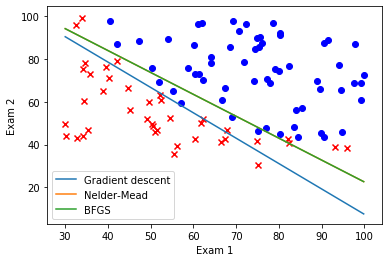

In [15]:
bfgs_optimization = minimize(
    fun=loss,
    x0=THETA_START,
    args=(FEATURES, TARGETS),
    method="BFGS",
    tol=ParamType("1e-6"),
)
display_optimization(bfgs_optimization, data_axes, "BFGS")
data_fig